## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import monai

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn.functional as F
import torchinfo
from box import Box
from icecream import ic
from lightning_fabric.fabric import Fabric
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc

EnvironmentNameNotFound: Could not find conda environment: pitn
You can list all discoverable environments with `conda info --envs`.




True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True

else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


In [4]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    # GPU information
    try:
        gpu_info = pitn.utils.system.get_gpu_specs()
        print(gpu_info)
    except NameError:
        print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

In [5]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2023-04-12T17:30:58.009655-04:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-32-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: edfb4c776bc83b091cca1df05ae627ce84bd7461

numpy     : 1.23.4
skimage   : 0.19.3
pandas    : 1.5.2
sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
matplotlib: 3.5.2
torch     : 1.13.1
torchinfo : 1.7.1
pitn      : 0.0.post1.dev258+g67cc03c.d20230208
nibabel   : 4.0.1
seaborn   : 0.12.1
einops    : 0.6.0
monai     : 1.0.1

==================================================GPU Specs==================================================
  id  Name              Driver Version      CUDA Version  Total Memory    uuid
----  ----------------  ----------------  --------------  --------------  ----------------------------------------
   

## Data Loading

In [6]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

In [7]:
model_predictions_dir = (
    Path("/data/srv/outputs/pitn/results/runs/")
    / "2023-04-04T12_51_09_super_res_odf_test"
)
inr_predictions_dir = model_predictions_dir / "INR"
trilin_predictions_dir = model_predictions_dir / "tri-linear"
inr_prediction_ims = list(inr_predictions_dir.glob("*predict*.nii.gz"))

test_subj_ids = list()
for im in inr_prediction_ims:
    subj_id = str(im.name[:6])
    test_subj_ids.append(subj_id)
test_subj_ids = sorted(test_subj_ids)
print(test_subj_ids)

inr_predictions = dict()
trilin_predictions = dict()
for subj_id in test_subj_ids:
    inr_p = pitn.utils.system.get_file_glob_unique(
        inr_predictions_dir, f"*{subj_id}*.nii.gz"
    )
    trilin_p = pitn.utils.system.get_file_glob_unique(
        trilin_predictions_dir, f"*{subj_id}*.nii.gz"
    )
    inr_predictions[subj_id] = inr_p
    trilin_predictions[subj_id] = trilin_p

['100307', '104820', '110613', '118730', '121618', '122317', '122822', '123925', '124422', '126426', '127933', '131924', '133827', '144428', '145127', '147737', '149236', '154532', '164939', '165032', '169545', '173536', '173940', '178849', '179346', '180836', '185038', '191336', '195647', '195849', '200210', '202113', '204016', '251833', '275645', '293748', '298051', '300618', '353740', '360030', '385450', '419239', '445543', '465852', '495255', '500222', '510225', '518746', '529549', '581450', '645450', '654350', '749058', '767464', '800941', '803240', '812746', '825048', '843151', '849971', '859671', '896778', '929464', '933253', '965367', '987074', '993675', '994273']


### Ground-Truth Data

In [8]:
with warnings.catch_warnings(record=True) as warn_list:
    test_paths_dataset = pitn.data.datasets.HCPfODFINRDataset(
        subj_ids=test_subj_ids[:3],  #!DEBUG
        dwi_root_dir=hcp_full_res_data_dir,
        fodf_root_dir=hcp_full_res_fodf_dir,
        lr_dwi_root_dir=hcp_low_res_data_dir,
        lr_fodf_root_dir=hcp_low_res_fodf_dir,
    )
    cached_test_dataset = monai.data.CacheDataset(
        test_paths_dataset,
        transform=test_paths_dataset.default_pre_sample_tf(0, skip_sample_mask=True),
        copy_cache=False,
        num_workers=2,
    )
    test_dataset = pitn.data.datasets.HCPfODFINRWholeVolDataset(
        cached_test_dataset,
        transform=pitn.data.datasets.HCPfODFINRWholeVolDataset.default_tf(),
    )
test_dataloader = monai.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

Loading dataset: 100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


In [9]:
# test_paths_dataset = pitn.data.datasets.HCPfODFINRDataset(
#     subj_ids=test_subj_ids,
#     dwi_root_dir=hcp_full_res_data_dir,
#     fodf_root_dir=hcp_full_res_fodf_dir,
#     lr_dwi_root_dir=hcp_low_res_data_dir,
#     lr_fodf_root_dir=hcp_low_res_fodf_dir,
# )

# ground_truth = dict()
# for subj_id in test_subj_ids:
#     for d in test_paths_dataset:
#         if d['subj_id'] == subj_id:
#             ground_truth[subj_id] = d
#             break
#     assert subj_id in ground_truth.keys()

## Test Loop

In [10]:
results = dict()
results["subj_id"] = list()
results["model"] = list()
results["metric"] = list()
results["tissue"] = list()
results["SH_order"] = list()
results["SH_degree"] = list()
results["stat_name"] = list()
results["stat"] = list()

plotted = False
for sample in test_dataloader:
    subj_id = sample["subj_id"][0]
    print(subj_id)

    gt = sample["fodf"][0]
    mask = sample["mask"][0].bool()
    fivett_seg = sample["fivett"][0].bool()

    wm_mask = fivett_seg[2, None] * mask
    gm_mask = fivett_seg[0, None] * mask
    csf_mask = fivett_seg[3, None] * mask

    inr_pred_f = inr_predictions[subj_id]
    trilin_pred_f = trilin_predictions[subj_id]

    inr_pred_im = nib.load(inr_pred_f)
    trilin_pred_im = nib.load(trilin_pred_f)

    inr_pred = torch.from_numpy(inr_pred_im.get_fdata())
    inr_pred = einops.rearrange(inr_pred.to(gt), "x y z c -> c x y z")

    trilin_pred = torch.from_numpy(trilin_pred_im.get_fdata())
    trilin_pred = einops.rearrange(trilin_pred.to(gt), "x y z c -> c x y z")

    if not plotted and random.random() > 0.9:
        fig = plt.figure(dpi=120)
        pitn.viz.plot_vol_slices(gt[0], mask, inr_pred[0], trilin_pred[0], fig=fig)
        plt.show()
        plotted = True

    i_degree_order = 0
    for degree in range(0, 9, 2):
        for order in range(-degree, degree + 1):
            gt_i = gt[i_degree_order, None]
            inr_i = inr_pred[i_degree_order, None]
            trilin_i = trilin_pred[i_degree_order, None]

            # MSE
            for model_pred_i, model_name in zip(
                (inr_i, trilin_i), ("inr", "tri-linear")
            ):

                se = F.mse_loss(model_pred_i, gt_i, reduction="none")
                for mask, mask_name in zip(
                    (wm_mask, gm_mask, csf_mask, mask), ("WM", "GM", "CSF", "all")
                ):
                    se_masked = se[mask]

                    for stat, stat_name in zip(
                        (
                            torch.mean(se_masked).detach().cpu().item(),
                            torch.std(se_masked).detach().cpu().item(),
                            torch.median(se_masked).detach().cpu().item(),
                        ),
                        ("mean", "std", "median"),
                    ):
                        results["subj_id"].append(subj_id)
                        results["model"].append(model_name)
                        results["metric"].append("mse")
                        results["SH_order"].append(order)
                        results["SH_degree"].append(degree)
                        results["tissue"].append(mask_name)
                        results["stat_name"].append(stat_name)
                        results["stat"].append(stat)

            i_degree_order += 1

    # mse = F.mse_loss(pred, gt, reduction='none')
    # mse = mse[mask]
    # results['subj_id'].append(subj_id)
    # results['model'].append('INR')
    # results['metric'].append('squared-error')
    # results['mean'].append(mse.mean().cpu().item())
    # results['std'].append(torch.std(mse).cpu().item())

# results['model'] = list()
# results['metric'] = list()
# results['tissue'] = list()
# results['SH_order'] = list()
# results['SH_degree'] = list()
# results['mean'] = list()
# results['median'] = list()
# results['std'] = list()

100307
104820
110613


/home/tas6hh/miniconda/envs/pitn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



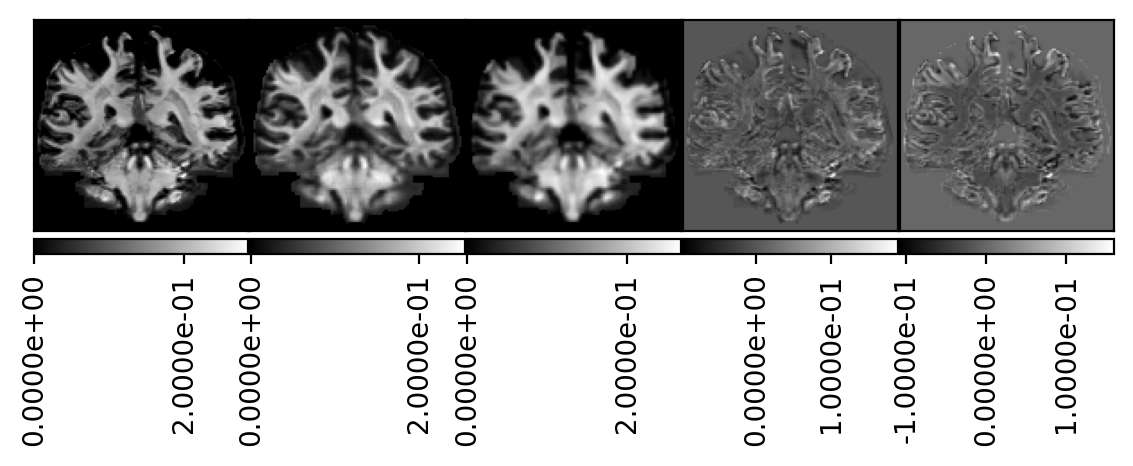

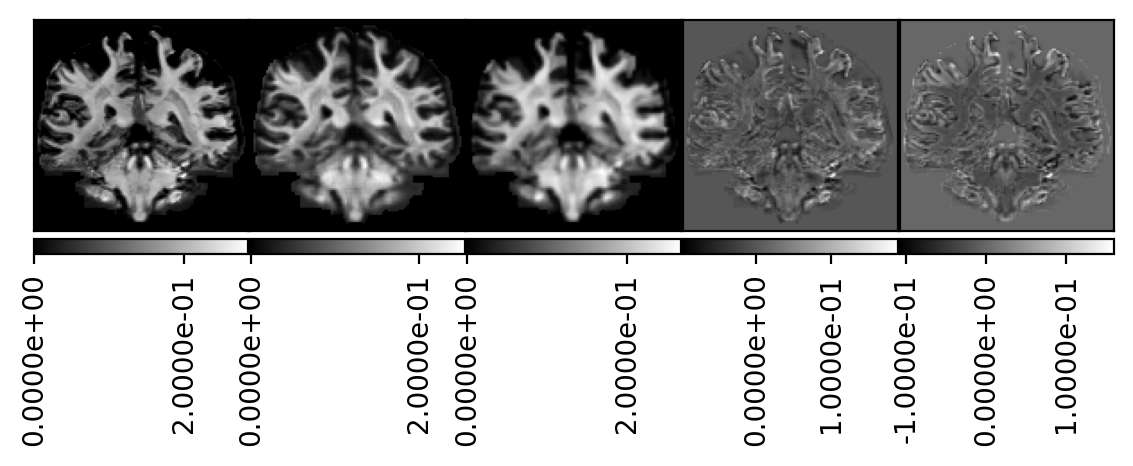

In [11]:
fig = plt.figure(dpi=200)
# pitn.viz.plot_vol_slices(gt[0], inr_pred[0], gt[0] - inr_pred[0], gt[0] - trilin_pred[0], vol_labels=["GT", "INR", "GT-INR Diff", "GT-Trilin Diff"], fig=fig);
slice_idx = (slice(None), 58, slice(None))
pitn.viz.plot_im_grid(
    gt[0][slice_idx].rot90(),
    inr_pred[0][slice_idx].rot90(),
    trilin_pred[0][slice_idx].rot90(),
    (gt[0] - inr_pred[0])[slice_idx].rot90(),
    (gt[0] - trilin_pred[0])[slice_idx].rot90(),
    nrows=1,
    colorbars="cols",
)

In [14]:
# skimage.io.imsave()
skimage.io.imsave("/tmp/gt.png", gt[0][slice_idx].rot90().cpu().numpy())
inr_pred[0][slice_idx].rot90()
trilin_pred[0][slice_idx].rot90()

2023-04-12 17:33:07,640 - Lossy conversion from float32 to uint8. Range [-4.0919607613432163e-07, 0.28490516543388367]. Convert image to uint8 prior to saving to suppress this warning.


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
inr_pred[0][slice_idx].max() / 0.2541
gt[0][slice_idx].max()

tensor(0.2849)

2023-04-10 18:20:47,332 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2023-04-10 18:20:47,334 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


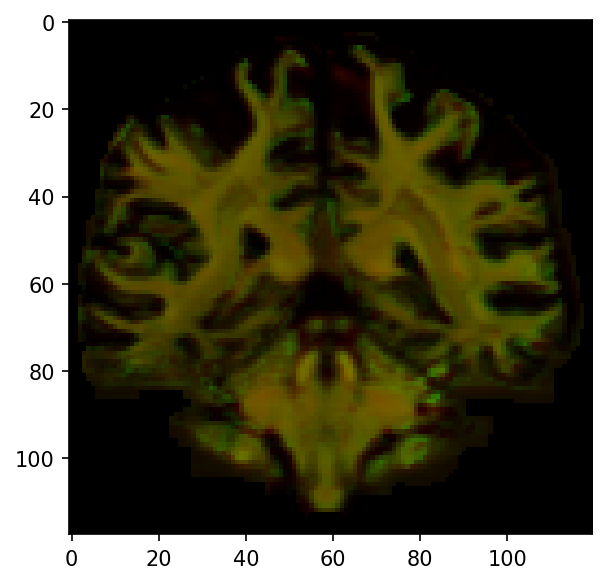

In [54]:
plt.figure(dpi=150)
# plt.imshow(
#     torch.stack(
#         [
#             inr_pred[0][slice_idx] / 0.2541,
#             gt[0][slice_idx]/0.2849,
#             torch.zeros_like(inr_pred[0][slice_idx]),
#             torch.ones_like(inr_pred[0][slice_idx]),
#         ],
#         -1,
#     )
#     .rot90()
#     .cpu()
#     .numpy()
# )

plt.imshow(
    torch.stack(
        [
            inr_pred[0][slice_idx] / 0.2541,
            torch.zeros_like(inr_pred[0][slice_idx]),
            torch.zeros_like(inr_pred[0][slice_idx]),
            torch.ones_like(inr_pred[0][slice_idx]),
        ],
        -1,
    )
    .rot90()
    .cpu()
    .numpy()
)

plt.imshow(
    torch.stack(
        [
            torch.zeros_like(inr_pred[0][slice_idx]),
            gt[0][slice_idx] / 0.2849,
            torch.zeros_like(inr_pred[0][slice_idx]),
            torch.ones_like(inr_pred[0][slice_idx]) * 0.5,
        ],
        -1,
    )
    .rot90()
    .cpu()
    .numpy()
)

In [10]:
results = pd.DataFrame.from_dict(results)
results
results.to_csv(model_predictions_dir / "image_comparison_metric_results.csv")

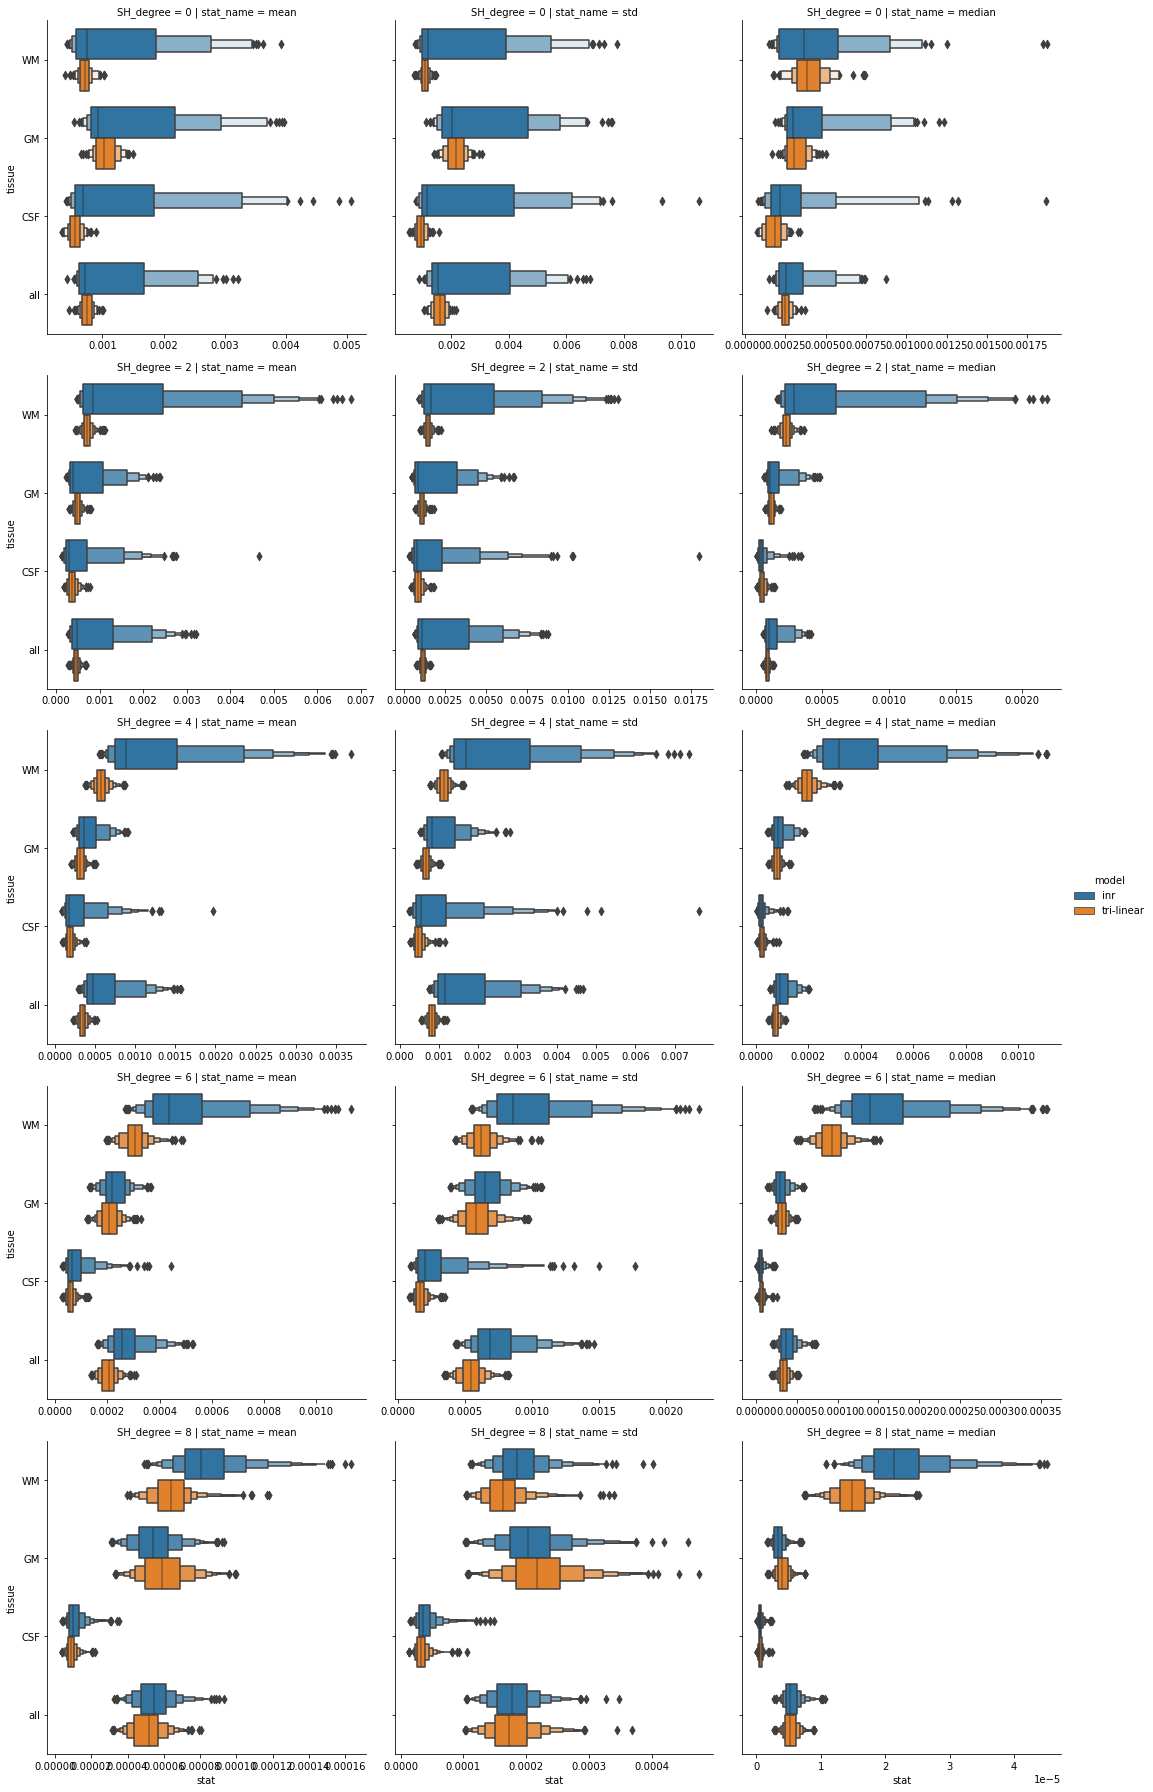

In [32]:
sns.catplot(
    results,
    x="stat",
    y="tissue",
    hue="model",
    row="SH_degree",
    col="stat_name",
    errorbar=None,
    kind="boxen",
    sharex=False,
)

In [25]:
results[(results.tissue == "WM") & (results.stat_name == "median")]

,subj_id,model,metric,tissue,SH_order,SH_degree,stat_name,stat
2,100307,inr,mse,WM,0,0,median,0.000416
14,100307,tri-linear,mse,WM,0,0,median,0.000472
26,100307,inr,mse,WM,-2,2,median,0.000639
38,100307,tri-linear,mse,WM,-2,2,median,0.000183
50,100307,inr,mse,WM,-1,2,median,0.000782
...,...,...,...,...,...,...,...,...
73382,994273,tri-linear,mse,WM,6,8,median,0.000014
73394,994273,inr,mse,WM,7,8,median,0.000017
73406,994273,tri-linear,mse,WM,7,8,median,0.000013
73418,994273,inr,mse,WM,8,8,median,0.000014


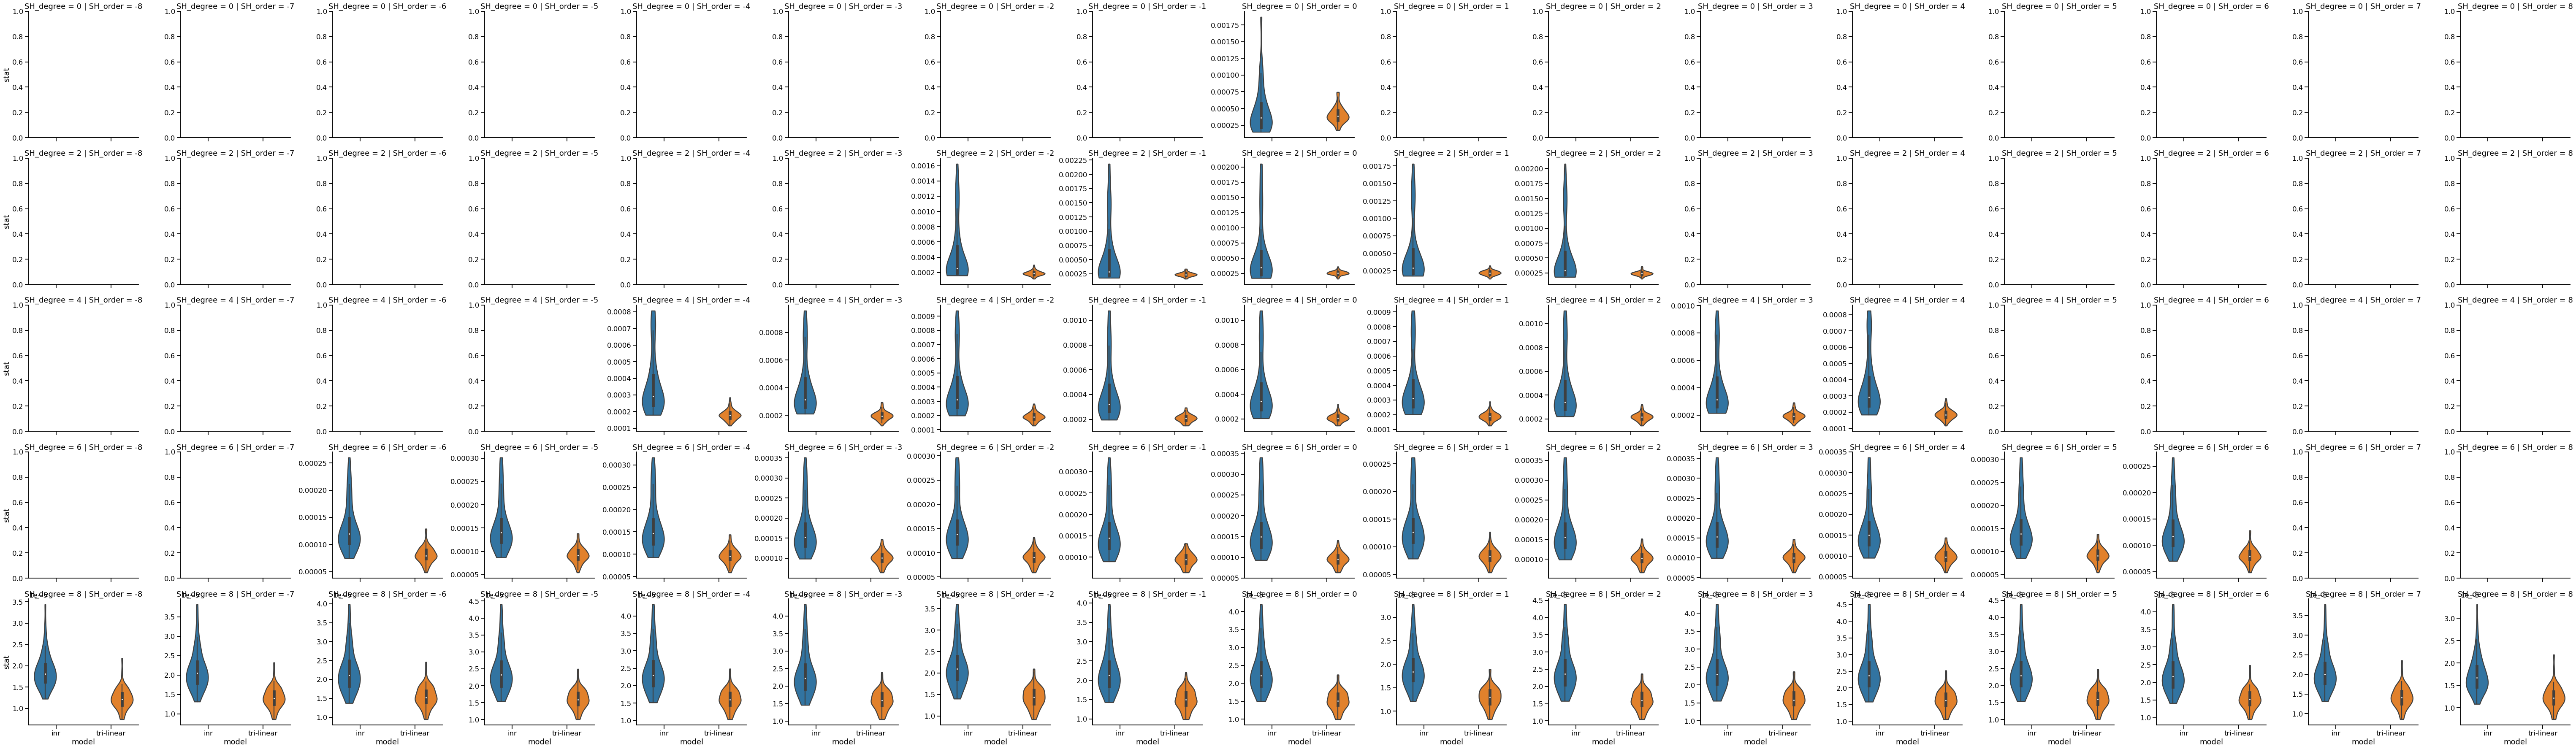

In [38]:
with sns.plotting_context("talk"):
    sns.catplot(
        results[(results.tissue == "WM") & (results.stat_name == "median")],
        x="model",
        y="stat",
        hue="model",
        row="SH_degree",
        # col="stat_name",
        col="SH_order",
        errorbar=None,
        kind="violin",
        # sharex=True,
        sharey=False,
        scale="width",
        cut=0,
    )

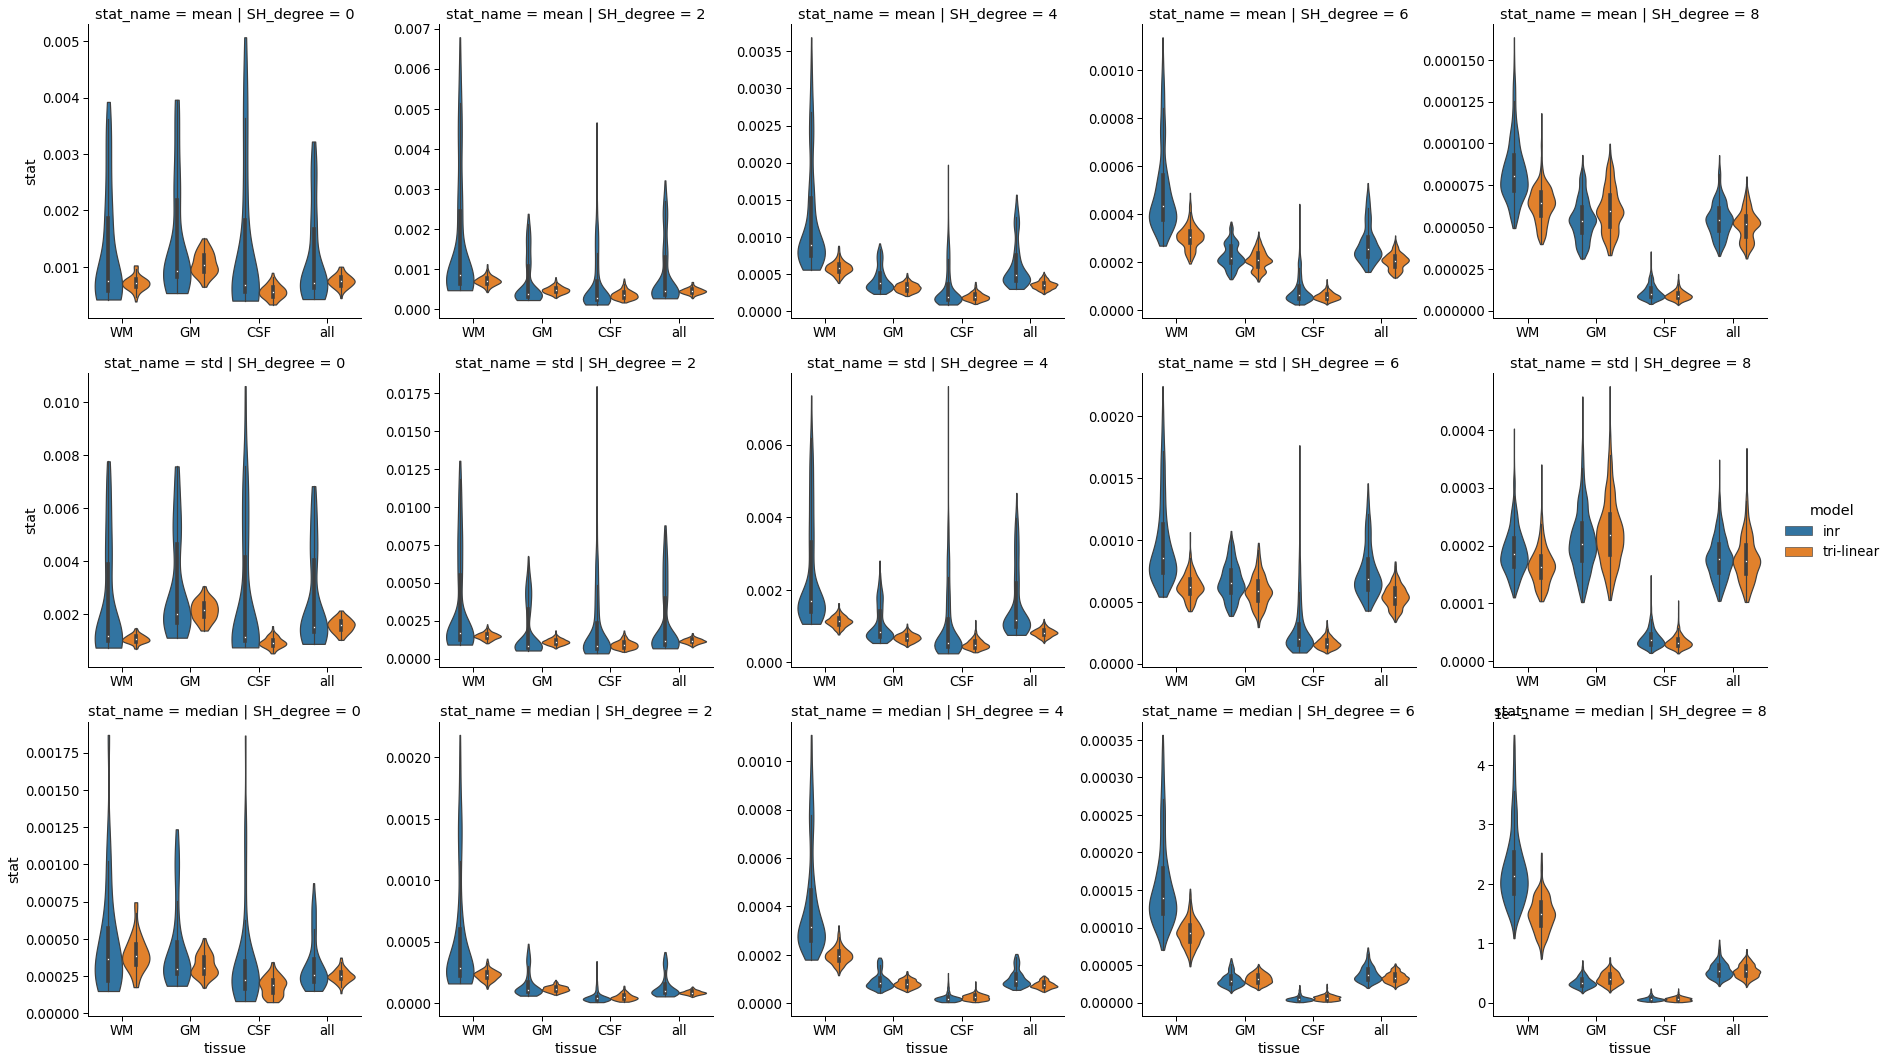

In [47]:
with sns.plotting_context("paper", 1.5):

    sns.catplot(
        results,
        x="tissue",
        y="stat",
        hue="model",
        col="SH_degree",
        row="stat_name",
        errorbar=None,
        kind="violin",
        sharex=False,
        sharey=False,
        scale="width",
        cut=0,
        grid=True,
    )

## 